# Machine Learning now

In [47]:
import pandas as pd
import os
import numpy as np
import sklearn 
import scipy.linalg as scplinag
from sklearn.neighbors import KDTree
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [48]:
%matplotlib inline

# Whole dataset and 10 NN 

Attributes as in Weinmann, 2013, plus relative height (Weinmann, 2014) 

In [49]:
# Define a data frame with all my data# Define  
FILE_PATH = r"../DATA"
FILE_NAME = r"/5_Data_ML_attributes_10NN.txt"
IMAGE_FILE_PATH = r"images"
df = pd.read_csv(FILE_PATH+FILE_NAME, delimiter=',')
df.rename(index=str, columns={"range": "relative_height"}, inplace = True)
df.head()

,X,Y,Z,class,lambda1,lambda2,lambda3,lambda4,lambda5,lambda6,lambda7,lambda8,local_density,radius_neighbourhood,relative_height,verticality
0,1905.494751,21122.037109,38.884586,2,0.189010,0.808544,0.002447,0.000028,0.997553,0.003467,0.000408,0.001349,25877.928393,0.046644,-2.497189,0.000847
1,1905.502930,21122.035156,38.883110,2,0.189010,0.808544,0.002447,0.000028,0.997553,0.003467,0.000408,0.001349,46635.546755,0.038329,-2.498982,0.000847
2,1905.512939,21122.033203,38.883949,2,0.189010,0.808544,0.002447,0.000028,0.997553,0.003467,0.000408,0.001349,75836.463465,0.032594,-2.498448,0.000847
3,1905.520874,21122.031250,38.882137,2,0.350668,0.646708,0.002624,0.000033,0.997376,0.003784,0.000451,0.001588,82825.790636,0.031650,-2.500576,0.000847
4,1905.531128,21122.029297,38.882839,2,0.391125,0.603946,0.004929,0.000041,0.995071,0.003847,0.000460,0.003054,82835.520399,0.031649,-2.500191,0.000902


In [50]:
rows, cols = df.shape
print "Number of instances", rows
print "Number of attributes", cols

Number of instances 11052294
Number of attributes 16


In [51]:
# Get rid of any NaNs or Inf / -Inf values 
df.replace([np.inf, -np.inf], np.nan, inplace = True)
# Test whether there are any NAN values in the data set 
if df.isnull().values.any() == False:
    print "No Nan in this data set"

No Nan in this data set


### I have made a mistake with the class names, therefore I need to re-name them now

In the file 3_CreateFinalClasses, I did not change the names of the classes properly. Therefore, I will have to re-name them now. 

Manually, not to confuse it.

In [57]:
# Road (second most points)
df["class"].where(df["class"] != 2, 1, inplace=True)
# Sidewalk
df["class"].where(df["class"] != 3, 2, inplace=True)
# Curb
df["class"].where(df["class"] != 4, 3, inplace=True)
# Building (most points)
df["class"].where(df["class"] != 5, 4, inplace=True)
# Other pole like objects
df["class"].where(df["class"] != 6, 5, inplace=True)
# Small poles
df["class"].where(df["class"] != 7, 6, inplace=True)
# Pedestrians
df["class"].where(df["class"] != 11, 7, inplace=True)
# 2 wheelers
df["class"].where(df["class"] != 12, 8, inplace=True)
# 4 wheelers
df["class"].where(df["class"] != 13, 9, inplace=True)
# 4 wheelers
df["class"].where(df["class"] != 13, 9, inplace=True)
# Potted plants
df["class"].where(df["class"] != 15, 11, inplace=True)

In [74]:
df['class'].value_counts()

4     6359799
1     3230632
2      884203
9      318893
10     105205
3       59854
8       39803
7       23070
6       18024
11       8969
5        3842
Name: class, dtype: int64

## Describe the dataset

Describe the values and then export the file as Descriptor_Table to txt

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11052294 entries, 0 to 11052293
Data columns (total 16 columns):
X                       float64
Y                       float64
Z                       float64
class                   int64
lambda1                 float64
lambda2                 float64
lambda3                 float64
lambda4                 float64
lambda5                 float64
lambda6                 float64
lambda7                 float64
lambda8                 float64
local_density           float64
radius_neighbourhood    float64
relative_height         float64
verticality             float64
dtypes: float64(15), int64(1)
memory usage: 1.4+ GB


In [53]:
# Describe it 
descriptor_table = df.describe()
descriptor_table.to_csv(FILE_PATH+'/Descriptor_Table_10NN.txt', index= False)
descriptor_table

,X,Y,Z,class,lambda1,lambda2,lambda3,lambda4,lambda5,lambda6,lambda7,lambda8,local_density,radius_neighbourhood,relative_height,verticality
count,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07
mean,1.902170e+03,2.122209e+04,4.107707e+01,4.323620e+00,7.272323e-01,2.597574e-01,1.301040e-02,1.066100e-04,9.869896e-01,7.738710e-03,1.160464e-03,7.891251e-03,6.590293e+04,4.583854e-02,6.328907e-01,8.334727e-01
std,5.672591e+00,6.058488e+01,3.908901e+00,2.335793e+00,3.033212e-01,2.943161e-01,4.188462e-02,4.056319e-04,4.188462e-02,1.007832e-02,3.256232e-03,2.321478e-02,9.103630e+04,2.597832e-02,4.002956e+00,6.343752e-01
min,1.885748e+03,2.112071e+04,3.666582e+01,2.000000e+00,1.910613e-04,7.869019e-09,-1.861377e-16,0.000000e+00,1.051526e-01,-1.898235e+00,2.930408e-05,-1.293093e-16,1.989907e-02,7.199637e-03,-3.973492e+00,1.000000e-06
25%,1.898891e+03,2.116849e+04,3.823697e+01,2.000000e+00,4.537933e-01,3.747290e-03,3.728969e-04,4.233501e-06,9.975814e-01,2.663344e-03,3.302484e-04,3.114053e-04,2.029871e+04,3.102148e-02,-2.404022e+00,1.417800e-02
50%,1.902271e+03,2.121777e+04,3.949983e+01,5.000000e+00,9.056916e-01,8.157165e-02,8.964773e-04,1.639803e-05,9.991035e-01,4.786404e-03,6.243500e-04,7.823540e-04,3.927642e+04,4.058735e-02,-9.467090e-01,9.917630e-01
75%,1.906592e+03,2.127548e+04,4.242671e+01,5.000000e+00,9.956128e-01,5.186690e-01,2.418645e-03,8.818397e-05,9.996271e-01,9.178983e-03,1.247711e-03,1.692042e-03,8.796634e+04,5.057609e-02,2.150309e+00,1.048504e+00
max,1.916770e+03,2.132869e+04,6.039886e+01,1.500000e+01,1.000000e+00,9.989550e-01,8.948474e-01,2.131494e-01,1.000000e+00,9.475825e-01,2.345641e+00,3.184605e-01,7.036751e+06,5.091242e+00,1.967205e+01,1.999999e+00


## Create feature data frame with only the features I would like to have for ML and also the class

In [54]:
df_features = df.iloc[:,3:]
df_features.drop(['radius_neighbourhood'], axis = 1, inplace = True)
df_features.head()

,class,lambda1,lambda2,lambda3,lambda4,lambda5,lambda6,lambda7,lambda8,local_density,relative_height,verticality
0,2,0.189010,0.808544,0.002447,0.000028,0.997553,0.003467,0.000408,0.001349,25877.928393,-2.497189,0.000847
1,2,0.189010,0.808544,0.002447,0.000028,0.997553,0.003467,0.000408,0.001349,46635.546755,-2.498982,0.000847
2,2,0.189010,0.808544,0.002447,0.000028,0.997553,0.003467,0.000408,0.001349,75836.463465,-2.498448,0.000847
3,2,0.350668,0.646708,0.002624,0.000033,0.997376,0.003784,0.000451,0.001588,82825.790636,-2.500576,0.000847
4,2,0.391125,0.603946,0.004929,0.000041,0.995071,0.003847,0.000460,0.003054,82835.520399,-2.500191,0.000902


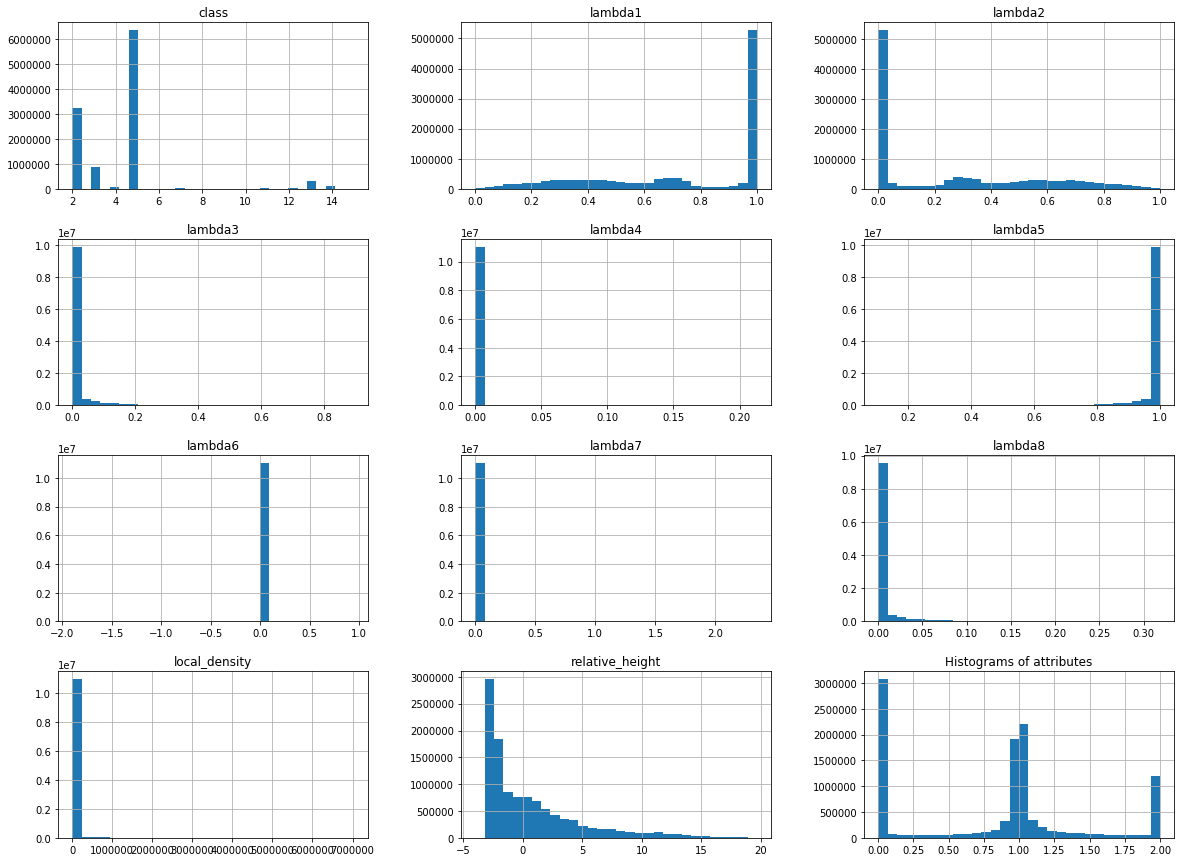

In [55]:
df_features.hist(bins = 30, figsize = (20,15)), plt.title('Histograms of attributes'),
plt.savefig(IMAGE_FILE_PATH+'/Histo_Attribtes_10NN.png')
plt.show();


In [56]:
df_features['class'].value_counts()

5     6359799
2     3230632
3      884203
13     318893
14     105205
4       59854
12      39803
11      23070
7       18024
15       8969
6        3842
Name: class, dtype: int64

## Check class distribution 

Classes:
    
1: Road - 2: Sidewalk - 3: Curb - 4: Building - 5: Other pole-like objects etc



In [30]:
df_features['class'].value_counts()

2    859
5    141
Name: class, dtype: int64

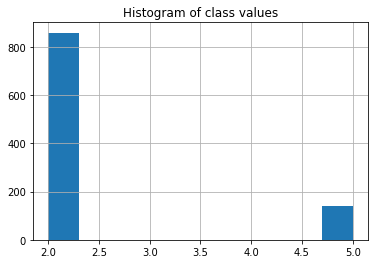

In [33]:
df_features['class'].hist(), plt.title('Histogram of class values'), plt.show();

In [19]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

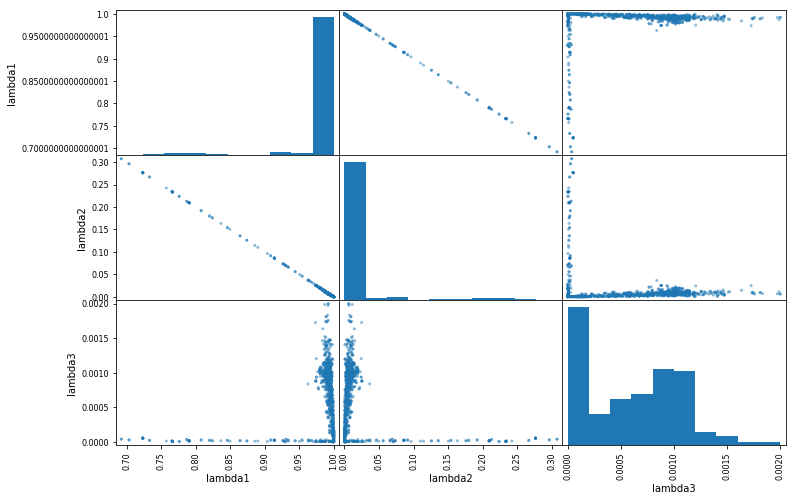

In [26]:
# This is interesting for comparing lambda 1, 2, 3 and we expect them to be correlated really 
scatter_matrix(df_features.iloc[:,1:4], figsize=(12,8)), plt.show();

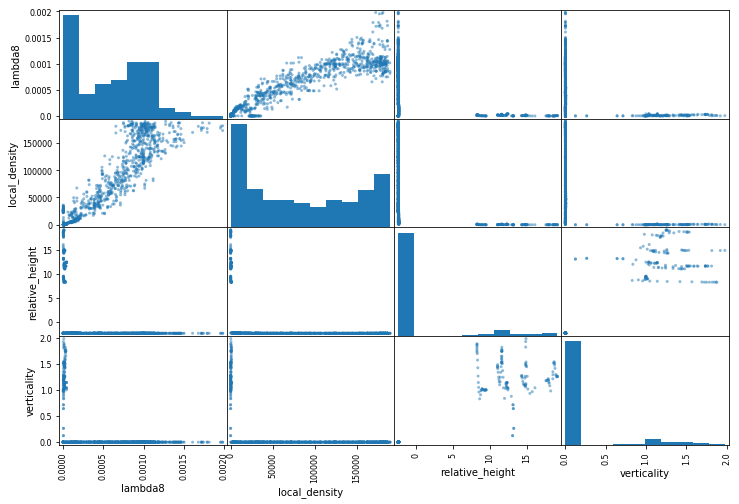

In [27]:
scatter_matrix(df_features.iloc[:,8:], figsize=(12,8)), plt.show();